<a href="https://colab.research.google.com/github/Sisasenkosi/Adversarial-attack-on-model-using-Fast-gradient-Method/blob/main/MedicalConfMtrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to create a model and then visualise its perfomance using a confusion matrix

In [1]:
import numpy as np
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras.layers import Input, Flatten, Rescaling
from keras.models import load_model

from art.attacks.evasion import FastGradientMethod, SaliencyMapMethod, CarliniL2Method, CarliniL0Method
from art.estimators.classification import KerasClassifier

In [10]:
!pip install art 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.7/595.7 KB 30.6 MB/s eta 0:00:00


In [12]:
!pip install adversarial-robustness-toolbox


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1


Model definition

In [2]:
inputs = keras.Input(shape=(150, 150, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Functions to define precision, recall and f1_score

In [3]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(loss="sparse_categorical_crossentropy",optimizer="rmsprop", metrics=["accuracy", recall_m, precision_m, f1_m])

Data loading

In [4]:
from keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/Medical_smallerData/train", image_size=(150, 150), batch_size=8)
validation_dataset = image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/Medical_smallerData/validation", image_size=(150, 150), batch_size=8)

Found 2997 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


Training the model

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Colab Notebooks/best_model/respDisease_model.hdf5",
    save_best_only=True,
    monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(patience=4)
]
history = model.fit(train_dataset,epochs=15,validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/15
375/375 [==============================] - 145s 387ms/step - loss: 0.7164 - accuracy: 0.6690 - recall_m: 1.2531 - precision_m: 11893334.0000 - f1_m: 1.3856 - val_loss: 0.3315 - val_accuracy: 0.8850 - val_recall_m: 1.1306 - val_precision_m: 0.7881 - val_f1_m: 0.9070
Epoch 2/15
375/375 [==============================] - 139s 371ms/step - loss: 0.4028 - accuracy: 0.8619 - recall_m: 1.1030 - precision_m: 0.7550 - f1_m: 0.8815 - val_loss: 0.2571 - val_accuracy: 0.8967 - val_recall_m: 1.1366 - val_precision_m: 0.7586 - val_f1_m: 0.8991
Epoch 3/15
375/375 [==============================] - 132s 352ms/step - loss: 0.2978 - accuracy: 0.8989 - recall_m: 1.0688 - precision_m: 0.7300 - f1_m: 0.8514 - val_loss: 0.2312 - val_accuracy: 0.9000 - val_recall_m: 1.0043 - val_precision_m: 0.6771 - val_f1_m: 0.7960
Epoch 4/15
375/375 [==============================] - 132s 352ms/step - loss: 0.2560 - accuracy: 0.9112 - recall_m: 1.0635 - precision_m: 0.7187 - f1_m: 0.8428 - val_loss: 0.2437 - va

### Accuracy and loss plots

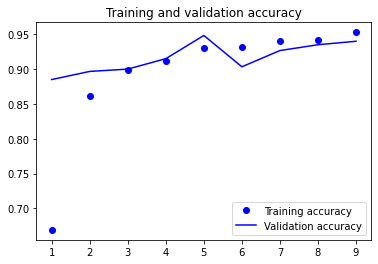

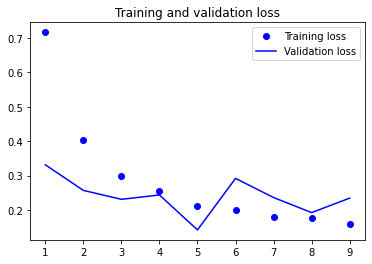

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [14]:
test_dataset = image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/Medical_smallerData/test", image_size=(150, 150), batch_size=8)
test_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/best_model/respDisease_model.hdf5", compile=False)
test_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
test_model.evaluate(test_dataset)

Found 420 files belonging to 3 classes.
53/53 [==============================] - 8s 130ms/step - loss: 0.1281 - accuracy: 0.9571 - f1_m: 0.8282 - precision_m: 0.7026 - recall_m: 1.0444


[0.12811845541000366,
 0.9571428298950195,
 0.8281804323196411,
 0.7026055455207825,
 1.0443620681762695]

Extract numpy arrays from tensorflow tensors for the test data

In [15]:
test_dataset = image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/Medical_smallerData/test", image_size=(150, 150), batch_size=32)
images = []
labels = []
for image_batch, label_batch in test_dataset:
    for image, label in zip(image_batch, label_batch):
        a = image.numpy()
        images.append(a)
        b = label.numpy()
        labels.append(b)
        
x_test = np.array(images)
y_test = np.array(labels)

Found 420 files belonging to 3 classes.


We need names since the model returns numbers. we need them for  plotting

In [16]:
class_names = ['lung_opacity', 'health', 'viral_pneumonia']

Code to generate the confusion matrix

14/14 [==============================] - 6s 386ms/step


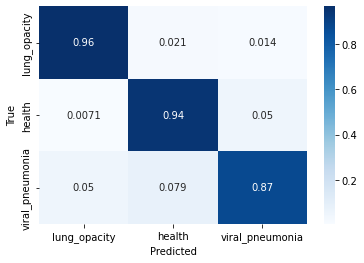

In [17]:

import seaborn as sns
import tensorflow as tf
def show_confusion_matrix(classifier, x_test, expected_labels, class_names):
    predictions = classifier.predict(x_test)
    num_predictions = predictions.shape[0]
    pred_labels = np.zeros((num_predictions), dtype=int)
    for pred, index in zip(predictions, range(num_predictions)):
        pred_labels[index] = np.argmax(pred)
        
    # Create a confusion matrix on training data.
    with tf.Graph().as_default():
        cm = tf.math.confusion_matrix(labels=expected_labels, predictions=pred_labels, num_classes=len(class_names))
        with tf.compat.v1.Session() as session:
            cm_out = session.run(cm)

    # Normalize the confusion matrix so that each row sums to 1.
    cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_out, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="Blues")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    
show_confusion_matrix(model, x_test, y_test, class_names)

Plotting some of the images plus their predictions

14/14 [==============================] - 4s 298ms/step


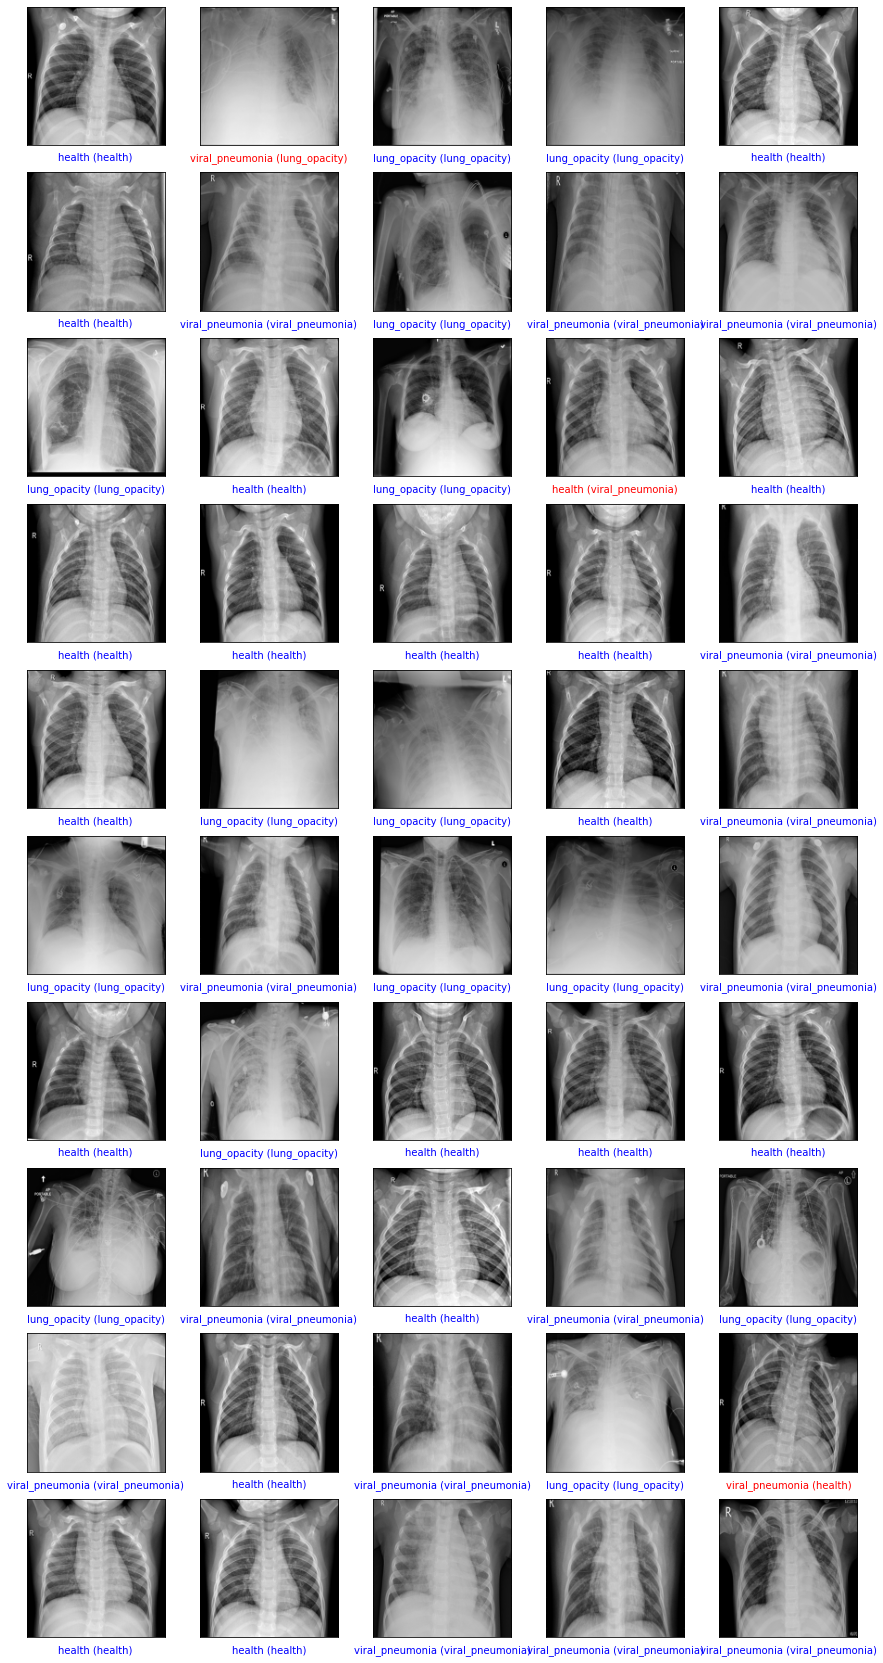

In [18]:
predictions = model.predict(x_test)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 30))
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pic = x_test[i] / 255
    plt.imshow(pic, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    plt.xlabel(class_names[y_test[i]])
    if predicted_label == y_test[i]:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel(f'{class_names[predicted_label]} ({class_names[y_test[i]]})', color=color)

In [20]:
tf.compat.v1.disable_eager_execution()

In [21]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/best_model/respDisease_model.hdf5', compile=False)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy", recall_m, precision_m, f1_m])
classifier = KerasClassifier(model=model, clip_values=(0, 255), use_logits=False)

Attacking the model

In [22]:
attack =  FastGradientMethod(estimator=classifier)
a = x_test[:50] / 255
adversarial_input = attack.generate(x=a)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


plot of  some images after attacking the model

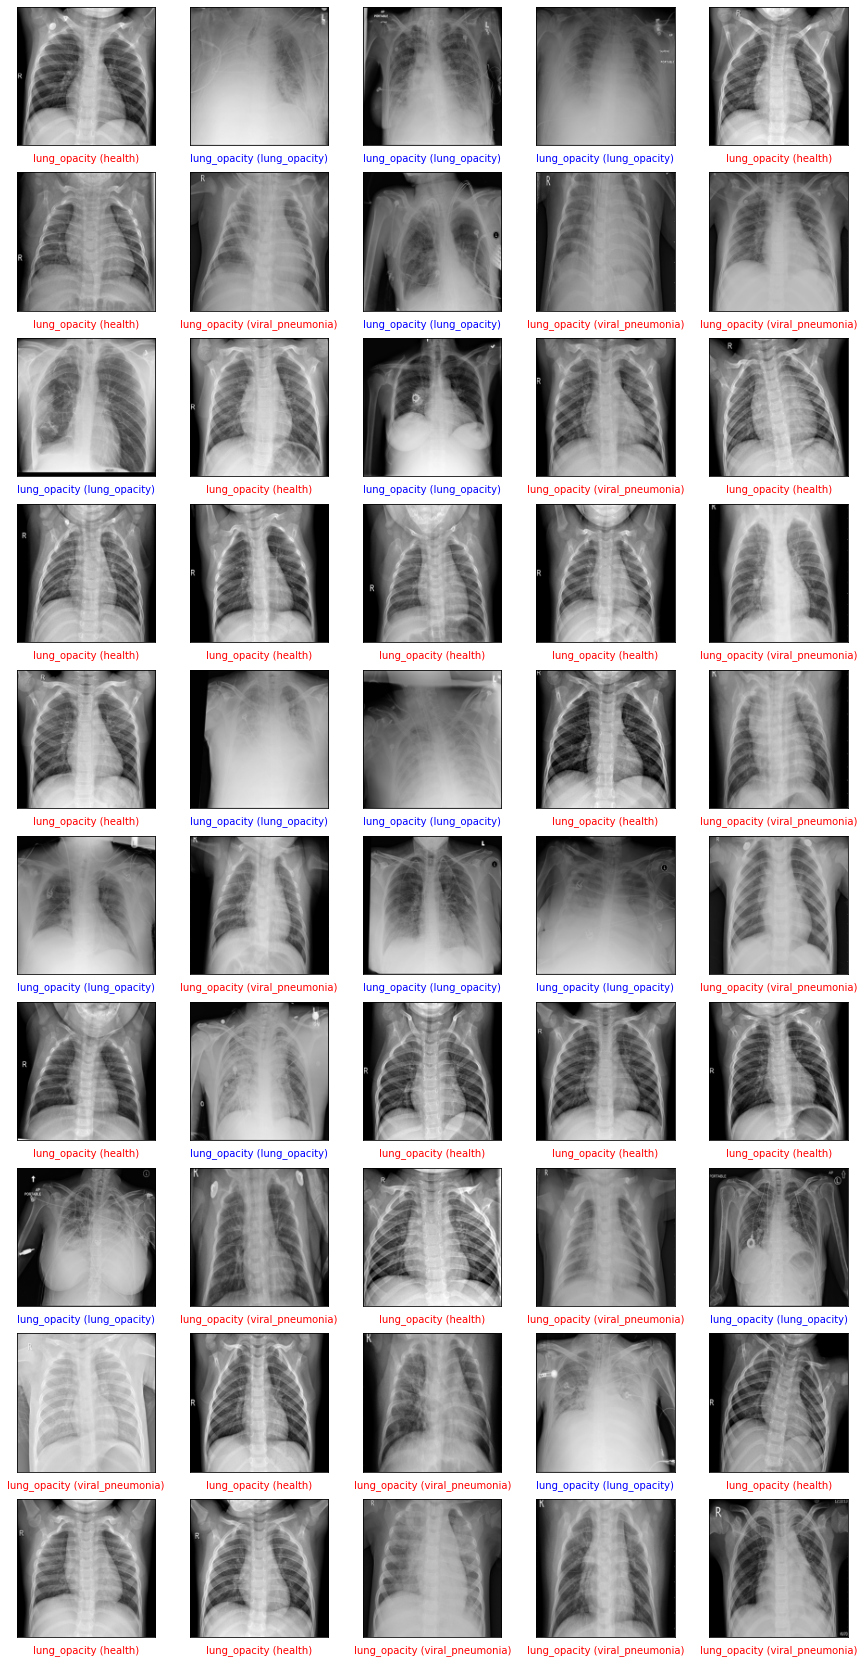

In [23]:
predictions = classifier.predict(adversarial_input)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 30))
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pic = x_test[i] / 255
    plt.imshow(pic, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    plt.xlabel(class_names[y_test[i]])
    if predicted_label == y_test[i]:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel(f'{class_names[predicted_label]} ({class_names[y_test[i]]})', color=color)